<a href="https://colab.research.google.com/github/zeliky/deep-learning-fp/blob/main/final_project_CustomCnn12_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from scipy.io import loadmat
import numpy as np
from PIL import Image,ImageShow
import matplotlib.pyplot as plt
import re
import os
import math
import random
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence, to_categorical
from concurrent.futures import ThreadPoolExecutor

In [2]:
drive.mount('/gdrive')


Mounted at /gdrive


In [3]:
BASE_PATH  = '/gdrive/MyDrive/deep-learning/final-project/data-sets/'
ORIGINAL_IMAGES = BASE_PATH + "0_Images/"
ROTATED_IMAGES =  BASE_PATH + "1_ImagesRotated/"
MEDIAN_BW_IMAGES =  BASE_PATH + "2_ImagesMedianBW/"
LINES_REMOVED_BW_IMAGES =  BASE_PATH + "3_ImagesLinesRemovedBW/"
LINES_REMOVED_IMAGES =  BASE_PATH + "4_ImagesLinesRemoved/"
DARK_LINES =  BASE_PATH + "5_DataDarkLines/"
SAMPLE_FILE_PATTERN = "lines{}_Page_{}.jpg"
METADATA_PATTERN = "lines{}_Page_{}.mat"
MODEL_CHECKPOINT_PATH = BASE_PATH + "model_checkpoints/"

NUMPY_STORAGE=  BASE_PATH +"numpy_storage/{}_train_validation.npz"
ALLOWED_TYPES = [ORIGINAL_IMAGES,ROTATED_IMAGES, MEDIAN_BW_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
TRAIN_TYPES =  [ LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
VALIDATE_TYPES =  [ ROTATED_IMAGES, MEDIAN_BW_IMAGES]
LINE_SHAPE = (225, 4965)
INPUT_SQUARE = (227, 227)

MODE_TRAIN = 'train'
MODE_VALIDATION = 'validation'
MODE_TEST = 'test'


In [4]:
class MetaData:
  @staticmethod
  def from_mat_data(data):
    metadata = MetaData()
    SCALE_FACTOR = data['SCALE_FACTOR'].flatten()[0]
    peaks_indices = data['peaks_indices'].flatten()
    metadata.min_y  = SCALE_FACTOR * min(peaks_indices)
    metadata.max_y  = SCALE_FACTOR *  max(peaks_indices)
    metadata.peaks_indices = [SCALE_FACTOR*a - metadata.min_y for a in  peaks_indices]
    metadata.index_of_max_in_peak_indices = data['index_of_max_in_peak_indices'].flatten()[0]
    metadata.delta = data['delta'].flatten()[0]
    metadata.top_test_area = data['top_test_area'].flatten()[0] - metadata.min_y
    metadata.bottom_test_area = data['bottom_test_area'].flatten()[0] - metadata.min_y
    metadata.total_lines = len(metadata.peaks_indices)
    return metadata

  def __repr__(self):
    return str(self.__dict__)


In [5]:
class ModelOptions:
    def __init__(self, **kwargs):
        self.num_classes = kwargs.get('num_classes', 10)
        self.batch_size = kwargs.get('batch_size', 100)
        self.image_height = kwargs.get('image_height', 150)
        self.image_width = kwargs.get('image_width', 150)
        self.num_channels = kwargs.get('num_channels', 1)
        self.max_sequence_length = kwargs.get('max_sequence_length', 40)
        self.random_shuffle_amount = kwargs.get('random_shuffle_amount', 0)
        #self.lstm_units = kwargs.get('lstm_units', 5)
        self.max_embedding_samples = kwargs.get('max_embedding_samples', 5)
        self.alpha = kwargs.get('alpha', 0.2)
        self.embedding_dim = kwargs.get('embedding_dim', 512)

    def __repr__(self):
        return str(self.__dict__)

In [6]:
class DataSet:
    def __init__(self):
        self.user_files = {}
        self.metadata = {}
        self._build_index()
        self.reset()

    def reset(self):
        self.images = {}

    def load_image(self, path, user_id):
        bin, id = self.user_files[user_id]
        image_type = self._image_type(path)

        file_name = SAMPLE_FILE_PATTERN.format(bin, id)
        image_path = "{}{}".format(path, file_name)
        image_metadata = self._get_cached_metadata(user_id)
        if image_metadata is None:
            image_metadata = self.image_metadata(user_id)
            self._cache_metadata(user_id, image_metadata)

        user_file = self._get_cached_image(image_type, user_id)
        if user_file is None:
            print('loading image from {}'.format(image_path))
            with open(image_path, 'r') as f:
                im = Image.open(image_path)
                user_file = UserFile(im, image_metadata)
                self._cache_image(image_type, user_id, user_file)
        return user_file

    def image_metadata(self, user_id):
        bin, id = self.user_files[user_id]
        file_name = METADATA_PATTERN.format(bin, id)
        metadata_path = "{}{}".format(DARK_LINES, file_name)
        # print(metadata_path)
        data = loadmat(metadata_path)
        return MetaData.from_mat_data(data)

    def _image_type(self, path):
        reg = re.search(r'\d+', path)
        return int(reg.group())


    def _build_index(self):
        directory_files = os.listdir(ORIGINAL_IMAGES)
        for idx, fname in enumerate(directory_files):
            pattern = re.search(r'lines(\d+)_Page_(\d+)', fname.replace(BASE_PATH, ''))
            self.user_files[idx] = (pattern.group(1), pattern.group(2))

    def _get_cached_image(self, image_type, user_id):
        if image_type in self.images and user_id in self.images[image_type]:
            return self.images[image_type][user_id]
        return None

    def _cache_image(self, image_type, user_id, image):
        if image_type not in self.images:
            self.images[image_type] = {}
        if user_id not in self.images[image_type]:
            self.images[image_type][user_id] = image

    def _get_cached_metadata(self, user_id):
        if user_id in self.metadata:
            return self.metadata[user_id]
        return None

    def _cache_metadata(self, user_id, metadata: MetaData):
        self.metadata[user_id] = metadata


# -------------------------------------------------------------------------------
#should be kept global so it will be shared by multi processes
full_data_set = DataSet()

In [7]:
class UserFile:
    def __init__(self, im, metadata):
        # image_arr = np.asarray(im.getchannel(0).getdata())
        self.im = im.copy()
        if im.mode != 'L':
            im = im.convert(mode='L')
        image_arr = np.asarray(im.getchannel(0))
        # image_arr = image_arr.reshape(im.height, im.width)
        # print(image_arr.shape)
        self.data = image_arr[metadata.min_y: metadata.max_y, :]
        self.metadata = metadata

    def get_testing_line(self):
        y_range = (self.metadata.top_test_area, self.metadata.bottom_test_area)
        return self.data[y_range[0]:y_range[1], :]

    def get_test_line_idx(self):
        for i in range(1, self.metadata.total_lines):
            if self.is_test_line(i):
                return i

    def get_all_lines(self, threshold=2000):
        for i in range(1, self.metadata.total_lines):
            yield self.get_line(i)

    def get_line(self, line_idx):
        y_range = (self.metadata.peaks_indices[line_idx - 1:line_idx + 1])
        return self.data[y_range[0]:y_range[1] + 30, :]

    def is_test_line(self, line_idx):
        bounderies = self.metadata.peaks_indices[line_idx - 1:line_idx + 1]
        return abs(int(bounderies[0]) - self.metadata.top_test_area) < 50 and abs(
            int(bounderies[1]) - self.metadata.bottom_test_area) < 50

    def show(self):
        image = Image.fromarray(self.data.astype(np.uint8))
        image.show()


In [8]:
class UserDataset:
    def __init__(self, user_id):
        self.user_id = user_id
        self.train_lines = []
        self.validation_lines = []
        self.all_lines = []
        self.test_line = None
        self.split_points = {}
        self.min_width = 20
        self.min_colored_pixels = 500 * 255

    def warmup(self):
        e = ThreadPoolExecutor(max_workers=len(ALLOWED_TYPES))
        futures = [e.submit(full_data_set.load_image, t, self.user_id) for t in ALLOWED_TYPES]
        results = [f.result() for f in futures]
        self.split_dataset()

    def split_dataset(self, train_split=0.8):
        bw_image = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        self.train_lines, self.validation_lines = select_train_validation_lines(bw_image)
        self.test_line = bw_image.get_test_line_idx()
        self.all_lines = sorted(self.train_lines + self.validation_lines)

    def get_letters(self, img_path, line_idx, target_size):
        split_points = self._get_characters_split_points(line_idx)
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            # print(f"get_letter shape {img.shape}")
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            yield np_img
        return

    def get_line_as_sequence(self, img_path, line_idx, max_sequence_length, target_size):
        sequence = []
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        split_points = self._get_characters_split_points(line_idx)
        for (x, y, w, h) in split_points:
            img = line[:, x:x + w]
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            sequence.append(np_img)
        return pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def random_line_generator(self, mode, max_sequence_length, target_size, sample_from_lines_amount=None,
                              sequence_length=None, original_only=False):
        while True:
            types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]
            img_path = random.choice(types)
            user_file = full_data_set.load_image(img_path, self.user_id)

            lines = self._get_lines_ids_set(mode)
            if sample_from_lines_amount is None:
                sample_from_lines_amount = random.randint(1, len(lines) - 1)
            selected_lines = random.sample(lines, sample_from_lines_amount)
            if sequence_length is None:
                sequence_length = random.randint(int(0.3 * max_sequence_length), max_sequence_length)
            sequence = []
            for _ in range(sequence_length):
                line_idx = random.choice(selected_lines)
                line = normalized_line(user_file.get_line(line_idx))
                split_points = self._get_characters_split_points(line_idx)
                (x, y, w, h) = random.choice(split_points)
                img = line[:, x:x + w]
                thumbnail = create_thumbnail(img, target_size)
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                sequence.append(np_img)
            yield pad_sequence(max_sequence_length, sequence, target_size[0], target_size[1], 1)

    def random_letters_generator(self, mode, target_size, random_shuffle_amount=1, original_only=False):
        while True:
            types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]
            img_path = random.choice(types)
            user_file = full_data_set.load_image(img_path, self.user_id)

            lines = self._get_lines_ids_set(mode)
            line_idx = random.choice(lines)
            line = normalized_line(user_file.get_line(line_idx))
            split_points = self._get_characters_split_points(line_idx)
            split_index = random.randint(0, len(split_points) - 1)
            (x, y, w, h) = split_points[split_index]

            img = line[:, x:x + w]
            thumbnails = [create_thumbnail(img, target_size) for _ in range(random_shuffle_amount)]
            for i, thumbnail in enumerate(thumbnails):
                np_im = np.array(thumbnail, dtype=np.float32) / 255
                np_img = np_im.reshape(target_size[0], target_size[1], 1)
                # print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w} rand:{i}")
                yield np_img, img_path, line_idx, split_index

    def get_letter(self, img_path, line_idx, split_index, target_size):
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        split_points = self._get_characters_split_points(line_idx)
        (x, y, w, h) = split_points[split_index]
        img = line[:, x:x + w]
        thumbnail = create_thumbnail(img, target_size)
        np_im = np.array(thumbnail, dtype=np.float32) / 255
        return np_im.reshape(target_size[0], target_size[1], 1)

    def _get_lines_ids_set(self, mode):
        if mode == MODE_TRAIN:
            return self.train_lines
        elif mode == MODE_VALIDATION:
            return self.validation_lines
        return [self.test_line]

    def _get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]
        img = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        line = normalized_line(img.get_line(idx))
        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > self.min_width:
                sub_img = line[:, x:x + w]
                # print(f"_get_characters_split_points line \t {idx}\t{x}\t{x+w}\t{sub_img.sum()}")
                if sub_img.sum() > self.min_colored_pixels:
                    split_points.append((x, y, w, h))

        self.split_points[idx] = sorted(split_points, key=lambda tup: tup[0])
        # print( self.split_points[idx])
        return self.split_points[idx]




In [9]:
def image_dots(img_data, threshold=50):
    height, width = img_data.shape
    for i in range(height):
        line = ''
        for j in range(width):
            if img_data[i, j] < threshold:
                line += ' '
            else:
                line += '.'
        print(line)


def show_line(line_data):
    image = Image.fromarray(line_data.astype(np.uint8))
    image.show()


def is_empty_line(line_data, threshold=5000):
    values = line_data.flatten()
    sum = values[values < 50].sum()
    # print("is_empty_line {}".format(sum))
    return sum < threshold


def normalized_line(line_data):
    desired_shape = LINE_SHAPE
    # normalized_data =  (255 - line_data) / 255.0
    normalized_data = (255 - line_data)
    pad_rows = max(0, desired_shape[0] - normalized_data.shape[0])
    pad_cols = max(0, desired_shape[1] - normalized_data.shape[1])

    padded_array = np.pad(normalized_data, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array


def select_train_validation_lines(user_image, train_split=0.8):
    rows = []
    for i, line in enumerate(user_image.get_all_lines()):
        idx = i + 1
        if not user_image.is_test_line(idx) and not is_empty_line(line):
            rows.append(idx)

    random.shuffle(rows)
    split_idx = int(len(rows) * train_split)
    return (rows[0:split_idx], rows[split_idx:])


def split_and_shuffle_array(arr, split_points):
    chunks = split_array(arr, split_points)
    np.random.shuffle(chunks)
    shuffled_array = np.concatenate(chunks, axis=1)
    return shuffled_array


def split_array(arr, split_points):
    chunks = []
    start_idx = 0
    for end_idx in split_points:
        chunk = arr[:, start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx
    last_chunk = arr[:, start_idx:]
    chunks.append(last_chunk)
    return chunks


def create_thumbnail(image_array, target_size):
    height, width = image_array.shape
    target_height, target_width = target_size
    org_image = Image.fromarray(image_array)

    random_scale_w = random.uniform(0.8, 1.2)
    random_scale_h = random.uniform(0.8, 1.2)
    random_rotate = random.randint(-15, 15)
    org_image_rs = org_image.resize((int(width * random_scale_w), int(height * random_scale_h)), Image.NEAREST)
    org_image_ro = org_image_rs.rotate(random_rotate, Image.NEAREST, expand=True)

    canvas = Image.new("L", (height, height), 0)
    if width < height:
        left = (height - width) // 2
        top = 0
        canvas.paste(org_image_ro, (left, top))
    else:
        scale_factor = height / width
        s_width = round(scale_factor * width)
        s_height = round(scale_factor * height)
        resized_image = org_image_ro.resize((s_width, s_height), Image.NEAREST)
        left = (height - s_width) // 2
        top = 0
        canvas.paste(resized_image, (left, top))
        del resized_image

    del org_image_rs
    del org_image_ro
    del org_image

    thumbnail = canvas.resize((target_width, target_height), Image.NEAREST)
    return thumbnail


def show_sequence(the_images):
    l = len(the_images)
    dim = math.ceil(math.sqrt(l))
    plt.clf()
    fig, axs = plt.subplots(dim, dim, figsize=(10, 10))
    k = 0
    for i in range(0, dim):
        for j in range(0, dim):
            img = the_images[k]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            k += 1
            if k == l:
                plt.show()
                return


def show_triplet(triplets):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    for k in range(0, 3):
        img = triplets[k]
        axs[k].imshow(img, cmap='gray')
        axs[k].axis('off')

    plt.show()


def pad_sequence(max_sequence_length, sequence, image_height, image_width, num_channels):
    sequence = np.asarray(sequence)
    padding_size = max_sequence_length - len(sequence)
    if padding_size > 0:
        padding_shape = (padding_size, image_height, image_width, num_channels)
        padding_images = np.zeros(padding_shape)
        padded_sequence = np.concatenate([sequence, padding_images], axis=0)
    else:
        padded_sequence = np.asarray(sequence)
    return padded_sequence

def pad_sequences(max_length, sequences, image_height, image_width, num_channels):
    # Pad sequences to have the same length (pad with zero images)
    padded_sequences = []
    for sequence in sequences:
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        if seq_len > max_length:
            sequence = sequence[:max_length]
            seq_len = len(sequence)

        num_padding = max_length - seq_len
        if num_padding > 0:
            sequence = np.concatenate(
                [sequence, np.zeros((num_padding, image_height, image_width, num_channels))])
        padded_sequences.append(sequence)
    return np.array(padded_sequences)


In [10]:
class FinalStopIteration(StopIteration):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)


In [52]:
class BaseLetterGenerator(Sequence):
    def __init__(self, mode, user_ids, options: ModelOptions):
        self.options = options
        self.user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        self.input_shape = (options.image_height, options.image_width)
        self.random_shuffle_amount = options.random_shuffle_amount
        self.users_ds = {}
        self.generators = {}
        self.mode = mode

    def __len__(self):
        return self.options.max_embedding_samples

    def on_epoch_end(self):
        self.generators = {}

    def reset_generators(self):
        self.generators = {}

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup()
            self.users_ds[user_id] = uds
        return self.users_ds[user_id]

    def get_letters_generator(self, user_id, is_anchor=False):
        key = f"anc{user_id}" if is_anchor else str(user_id)
        if key not in self.generators:
            # print(f"new generator for {user_id} anchor{is_anchor}")
            uds = self.get_user_ds(user_id)
            self.generators[key] = uds.random_letters_generator(mode=self.mode, target_size=self.input_shape,
                                                                original_only=is_anchor,
                                                                random_shuffle_amount=self.random_shuffle_amount)
        return self.generators[key]


class LettersGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options)

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        letters = 50
        random_shuffle_amount = self.options.random_shuffle_amount
        types = len(ALLOWED_TYPES)

        total_batches = (types * lines * users * letters * random_shuffle_amount) // self.options.batch_size
        # print(f"LettersGenerator __len__ {total_batches}")
        return total_batches

    def __getitem__(self, index):
        batch, labels = [], []
        users_count = len(self.user_ids)
        for s in range(self.options.batch_size):
            user_id = random.choice(self.user_ids)
            letter, _, _, _ = next(self.get_letters_generator(user_id))
            batch.append(letter)
            labels.append(to_categorical(self.id_to_class[user_id], num_classes=users_count))
            # labels.append(self.id_to_class[user_id]+1)

        if len(batch) == 0:
            batch = np.zeros((self.options.batch_size, self.options.image_height, self.options.image_width, 1))
            labels = np.zeros((self.options.batch_size,))
        # print(f"LettersGenerator batch: {len(batch)}")
        return np.asarray(batch), np.asarray(labels)


class TripletsGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options)

    def __getitem__(self, index):
        anchors, positives, negatives = [], [], []
        for _ in range(self.options.batch_size):
            positive_user, negative_user_id = random.sample(self.user_ids, 2)
            for triplet in self.get_triplets(positive_user, negative_user_id):
                if triplet is None:
                    positive_user, negative_user_id = random.sample(self.user_ids, 2)
                    continue
                anchor, positive, negative = triplet
                anchors.append(anchor)
                positives.append(positive)
                negatives.append(negative)

        return np.asarray(anchors), np.asarray(positives), np.asarray(negatives)

    def get_triplets(self, positive_user, negative_user_id):
        anc_letter, img_path, line_idx, split_index = next(self.get_letters_generator(positive_user, True))
        uds = self.get_user_ds(positive_user)
        filtered = list(filter(lambda im_type: im_type != img_path, ALLOWED_TYPES))
        img_path = random.choice(filtered)
        positive_letter = uds.get_letter(img_path, line_idx, split_index, self.input_shape)
        negative_letter, _, _, _ = next(self.get_letters_generator(negative_user_id, False))
        if anc_letter is not None and positive_letter is not None and negative_letter is not None:
            yield (anc_letter, positive_letter, negative_letter)


Display generators

In [ ]:

user_ids = [1,35,7,68]
num_classes = max(user_ids) + 1

num_epochs = 3

model_options = ModelOptions(
    num_classes=len(user_ids) ,
    batch_size=30,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=36,
    random_shuffle_amount=1,
    lstm_units=15
)

In [ ]:
model_options

{'num_classes': 1, 'batch_size': 100, 'image_height': 50, 'image_width': 50, 'num_channels': 1, 'max_sequence_length': 36, 'random_shuffle_amount': 1, 'max_embedding_samples': 5}

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_04.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_04.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_04.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_04.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_04.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_67.jpgloading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_67.jpg

loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_67.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_67.jpg
loading i

<Figure size 640x480 with 0 Axes>

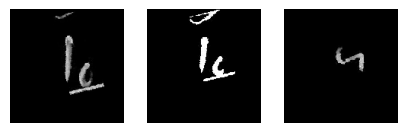

<Figure size 640x480 with 0 Axes>

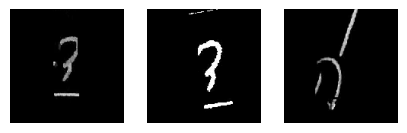

<Figure size 640x480 with 0 Axes>

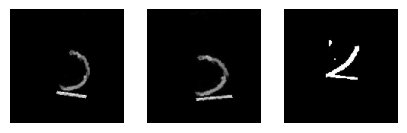

<Figure size 640x480 with 0 Axes>

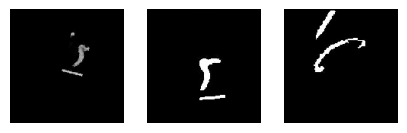

<Figure size 640x480 with 0 Axes>

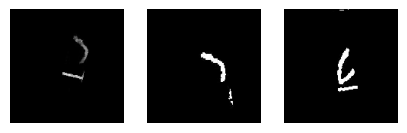

<Figure size 640x480 with 0 Axes>

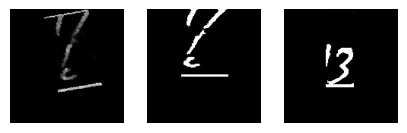

<Figure size 640x480 with 0 Axes>

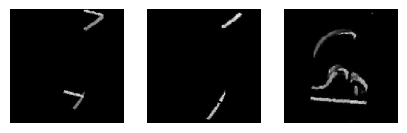

<Figure size 640x480 with 0 Axes>

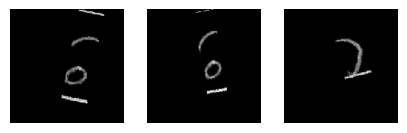

<Figure size 640x480 with 0 Axes>

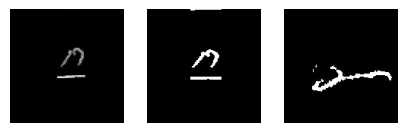

<Figure size 640x480 with 0 Axes>

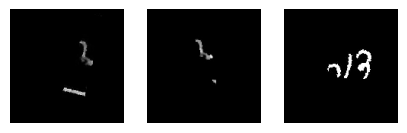

<Figure size 640x480 with 0 Axes>

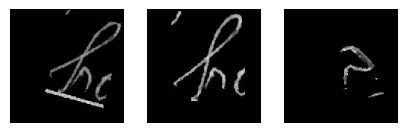

<Figure size 640x480 with 0 Axes>

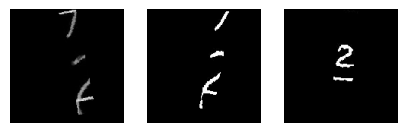

<Figure size 640x480 with 0 Axes>

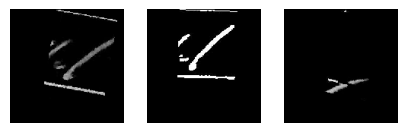

<Figure size 640x480 with 0 Axes>

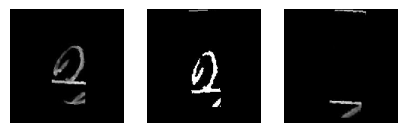

<Figure size 640x480 with 0 Axes>

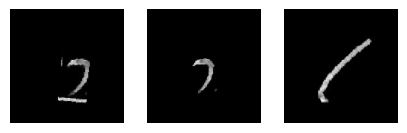

<Figure size 640x480 with 0 Axes>

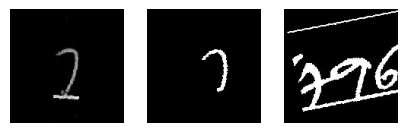

<Figure size 640x480 with 0 Axes>

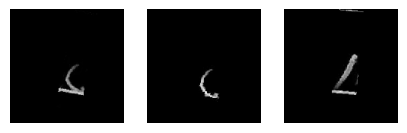

<Figure size 640x480 with 0 Axes>

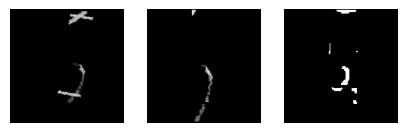

<Figure size 640x480 with 0 Axes>

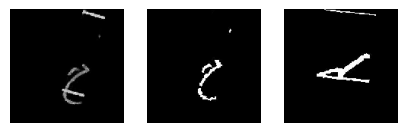

<Figure size 640x480 with 0 Axes>

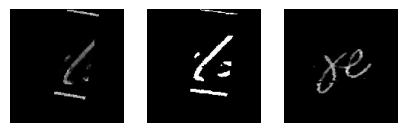

<Figure size 640x480 with 0 Axes>

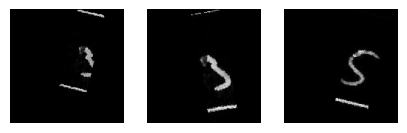

<Figure size 640x480 with 0 Axes>

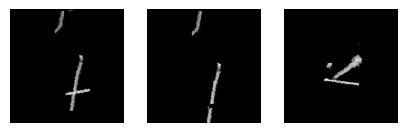

<Figure size 640x480 with 0 Axes>

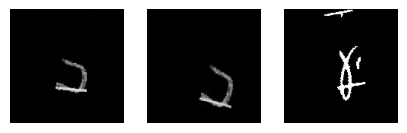

<Figure size 640x480 with 0 Axes>

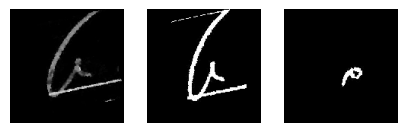

<Figure size 640x480 with 0 Axes>

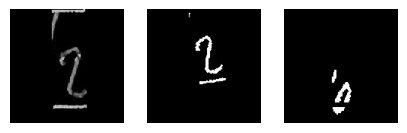

<Figure size 640x480 with 0 Axes>

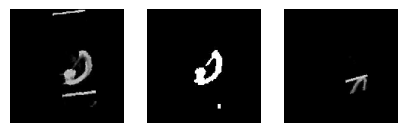

<Figure size 640x480 with 0 Axes>

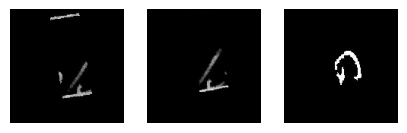

<Figure size 640x480 with 0 Axes>

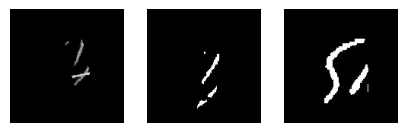

<Figure size 640x480 with 0 Axes>

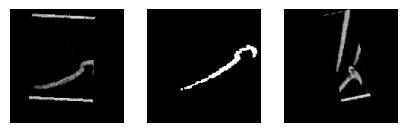

<Figure size 640x480 with 0 Axes>

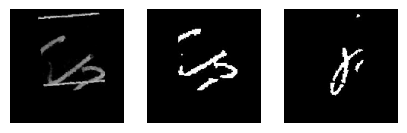

In [ ]:
def display_triplets():

  train_gen = TripletsGenerator(MODE_TRAIN, user_ids, model_options)
  valid_gen = TripletsGenerator(MODE_VALIDATION, user_ids, model_options)

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    anchors, possitives, negatives = batch_x
    for i in range(len(anchors)):
        show_triplet([anchors[i], possitives[i],negatives[i]])

    if i==5:
      break
    break
    #for id, letter in enumerate(batch_x):
    #  print(labels[id])
    #  #image_dots(letter.squeeze()*255)
    #  show_line(letter.squeeze())
    #break


    #break
  train_gen.on_epoch_end()

#full_data_set = DataSet()
display_triplets()

<Figure size 640x480 with 0 Axes>

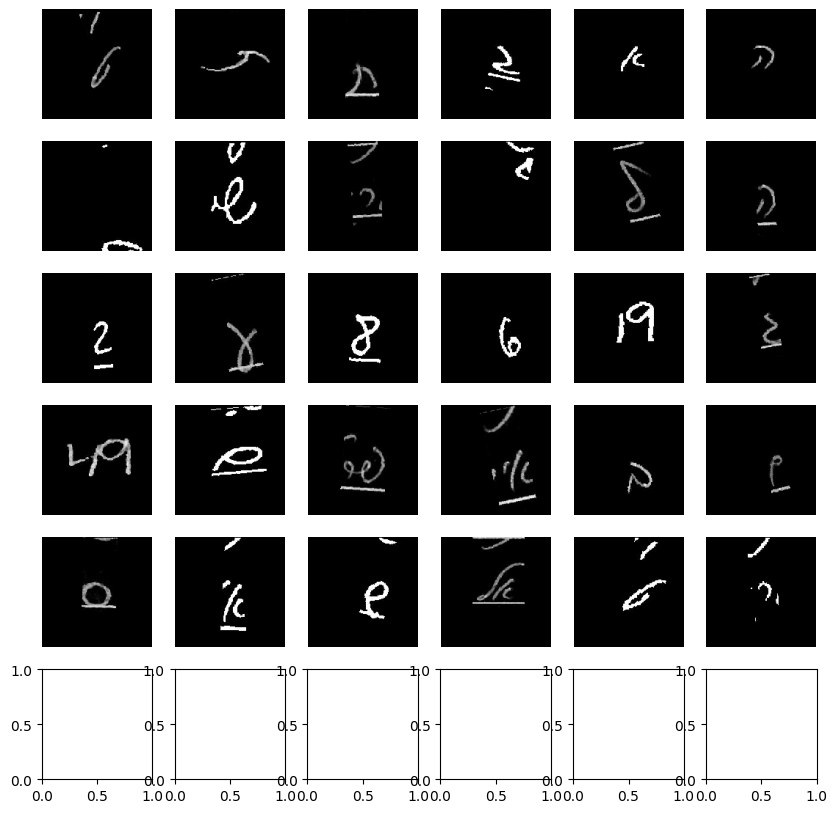

<Figure size 640x480 with 0 Axes>

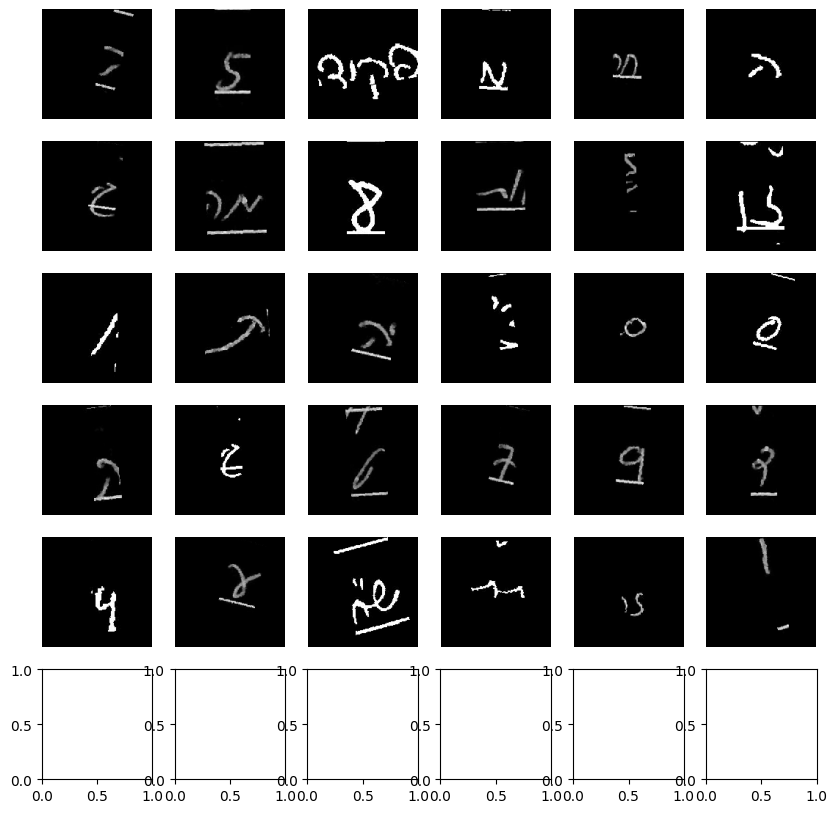

<Figure size 640x480 with 0 Axes>

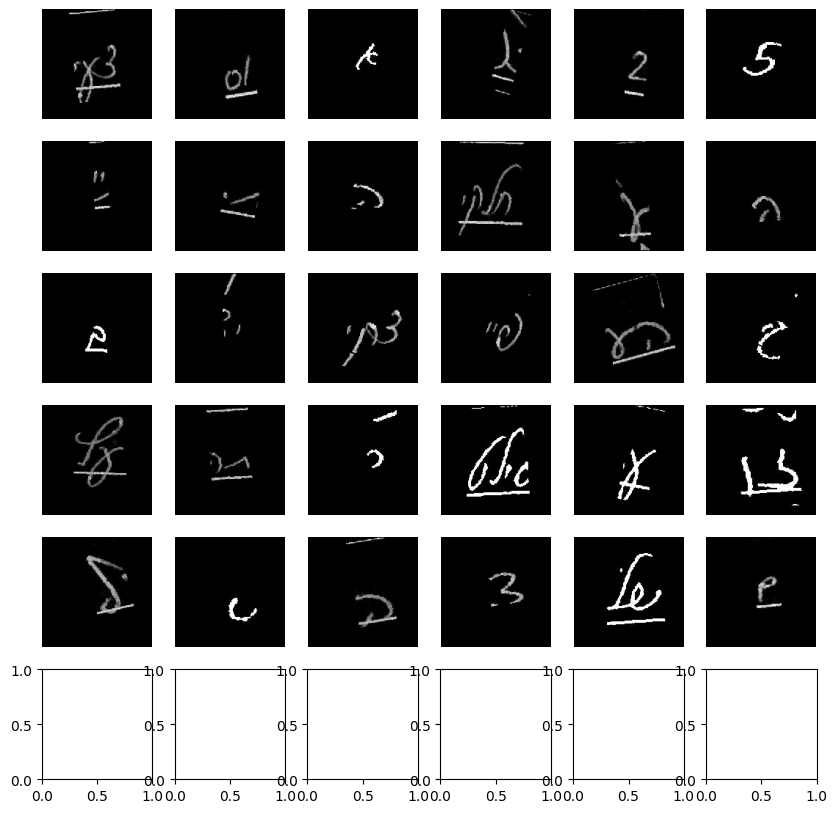

<Figure size 640x480 with 0 Axes>

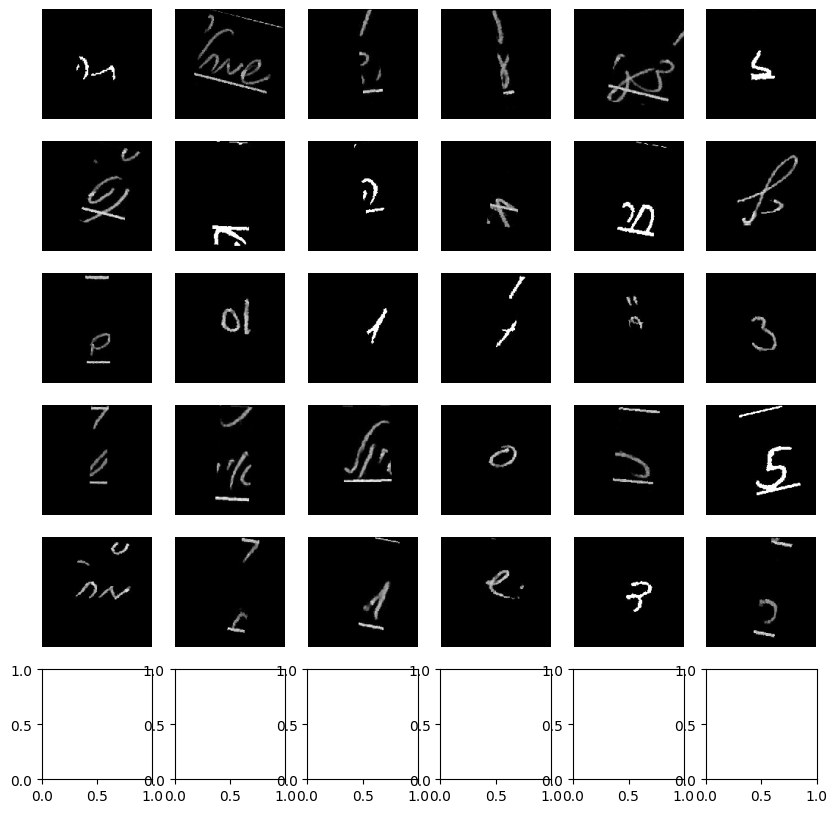

<Figure size 640x480 with 0 Axes>

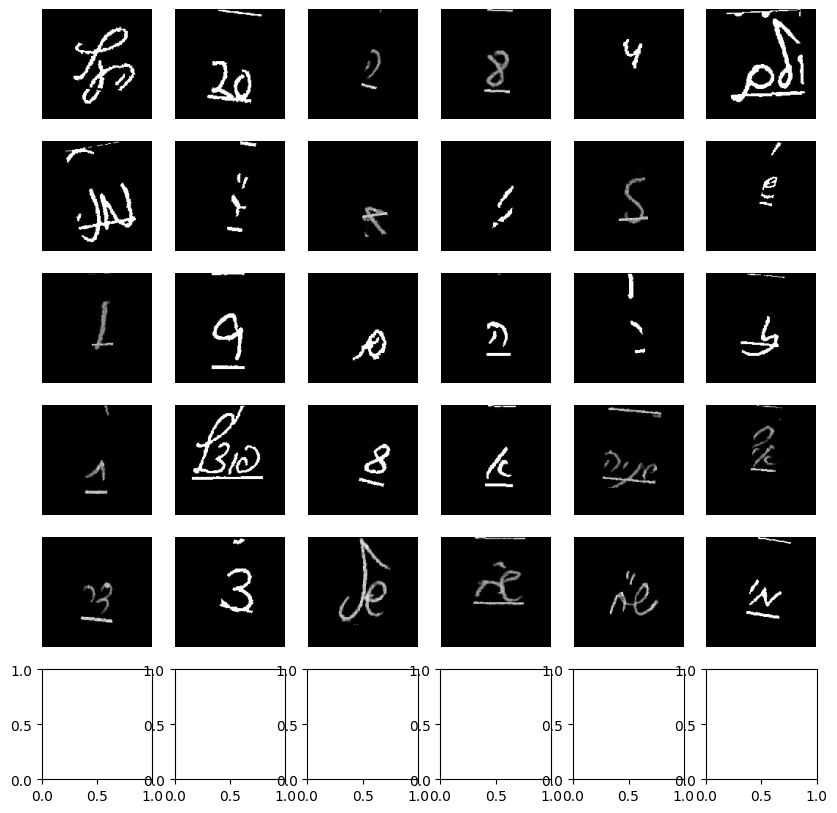

<Figure size 640x480 with 0 Axes>

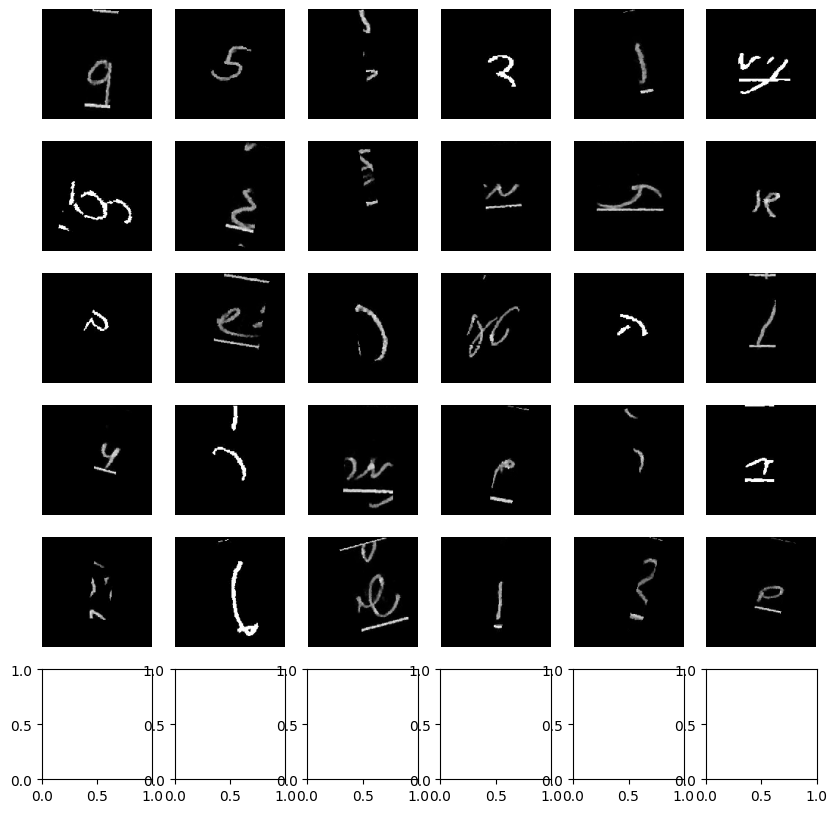

In [ ]:
def display_letters():
  train_gen = LettersGenerator(MODE_TRAIN, user_ids, model_options)
  valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options)

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    #print(labels)
    #pass
    show_sequence(batch_x)
    if i==5:
      break
    #for id, letter in enumerate(batch_x):
    #  print(labels[id])
    #  image_dots(letter.squeeze()*255)
    #  if i==10:
    #    break

    #  show_line(letter.squeeze())
    #break

  train_gen.on_epoch_end()

#full_data_set = DataSet()
display_letters()

In [ ]:

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [12]:
class EmbeddingModel:
    def __init__(self,input_shape, embedding_dim):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def get_model(self):
        input_layer = Input(shape=self.input_shape)

        # Convolutional layers
        x = Conv2D(filters=32, kernel_size=(11, 11), strides=(3, 3), padding='SAME', activation='relu')(input_layer)
        x = MaxPooling2D((3, 3))(x)
        x = Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='SAME', activation='relu')(x)
        x = MaxPooling2D((3, 3))(x)
        x = Conv2D(filters=128, kernel_size=(3, 3),strides=(3,3), padding='SAME', activation='relu')(x)
        x = Conv2D(filters=256, kernel_size=(3, 3), strides=(3,3), padding='SAME', activation='relu')(x)
        x = Conv2D(filters=64, kernel_size=(1,1), strides=(1, 1), activation='relu')(x)
        x = Conv2D(64, (1, 1), activation='relu')(x)

        x = Flatten()(x)
        embeddings = Dense(self.embedding_dim, activation='sigmoid')(x)
        return Model(inputs=input_layer, outputs=embeddings)

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
class SiameseModel(Model):
    def __init__(self, options: ModelOptions):
        super().__init__()
        self.siameseNetwork = SiameseNetwork(options=options).get_model()
        self.margin = options.alpha
        self.loss_tracker = Mean(name="loss")

    def _compute_distance(self, inputs):
        (anchor, positive, negative) = inputs
        # embed the images using the siamese network
        embeddings = self.siameseNetwork((anchor, positive, negative))
        anchor_embedding = embeddings[0]
        positive_embedding = embeddings[1]
        negative_embedding = embeddings[2]
        # calculate the anchor to positive and negative distance
        ap_distance = tf.reduce_sum(
            tf.square(anchor_embedding - positive_embedding), axis=-1
        )
        an_distance = tf.reduce_sum(
            tf.square(anchor_embedding - negative_embedding), axis=-1
        )

        # return the distances
        return ap_distance, an_distance

    def _compute_loss(self, ap_distance, an_distance):
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    def call(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (ap_distance, an_distance) = self._compute_distance(inputs)
        return ap_distance, an_distance

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            # compute the distance between the anchor and positive,
            # negative images

            (ap_distance, an_distance) = self._compute_distance(inputs)
            # calculate the loss of the siamese network
            loss = self._compute_loss(ap_distance, an_distance)
        # compute the gradients and optimize the model
        gradients = tape.gradient(
            loss,
            self.siameseNetwork.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.siameseNetwork.trainable_variables)
        )
        # update the metrics and return the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (ap_distance, an_distance) = self._compute_distance(inputs)
        # calculate the loss of the siamese network
        loss = self._compute_loss(ap_distance, an_distance)

        # update the metrics and return the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]


class SiameseNetwork:

    def __init__(self, options: ModelOptions):
        self.options = options
        self.input_shape = (options.image_height, options.image_width, 1)
        self.embedding_model = EmbeddingModel(self.input_shape, options.embedding_dim).get_model()

    def get_model(self):
        anchor_input = Input(self.input_shape, name='anchor_input')
        positive_input = Input(self.input_shape, name='positive_input')
        negative_input = Input(self.input_shape, name='negative_input')

        encoded_anchor = self.embedding_model(anchor_input)
        encoded_positive = self.embedding_model(positive_input)
        encoded_negative = self.embedding_model(negative_input)

        outputs = tf.concat([encoded_anchor, encoded_positive, encoded_negative], axis=1)
        siamese_net = Model(inputs=[anchor_input, positive_input, negative_input], outputs=outputs)

        return siamese_net

    def get_embedding_model(self):
        return self.embedding_model


In [49]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

filepath = MODEL_CHECKPOINT_PATH + "siamese-model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs=10
user_ids =[i for i in range(1,5)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=100,
    random_shuffle_amount=2,
    model = 0.2,
    embedding_dim=512
)

num_classes = model_options.num_classes
train_gen = TripletsGenerator(MODE_TRAIN, user_ids, model_options)
valid_gen = TripletsGenerator(MODE_VALIDATION, user_ids, model_options)
input_shape = (model_options.image_height,model_options.image_width ,1)

model = SiameseModel(model_options)
opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=None)
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
#                   validation_data=valid_gen, verbose=1)
                   validation_data=valid_gen, verbose=1, callbacks=callbacks_list)


ValueError: ignored

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input


class CustomCNN:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def get_model(self, options):
        model = Sequential()
        model.add(Input(shape=self.input_shape))

        # Adding Convolutional Layers
        for i in range(options['depth']):
            model.add(Conv2D(filters=options['filters'][i],
                             kernel_size=options['kernel_sizes'][i],
                             strides=options['strides'][i],
                             padding=options['padding'][i]))
            model.add(Activation(options['conv_activation']))
            if options['pooling'][i]:
                model.add(MaxPooling2D(pool_size=options['pool_sizes'][i],
                                       strides=options['pool_strides'][i]))

        model.add(Flatten())  # Flattening the 2D arrays for fully connected layers

        # Adding Fully Connected Layers
        for i in range(options['fc_layers']):
            model.add(Dense(options['fc_units'][i]))
            model.add(Activation(options['fc_activation']))
            model.add(Dropout(options['dropout_rate']))

        # Output Layer
        model.add(Dense(options['num_classes'], activation='softmax'))

        return model




In [ ]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):
     return self.initial_learning_rate / (step + 1)


In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = MODEL_CHECKPOINT_PATH + "model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs=10
user_ids =[i for i in range(1,5)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=100,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=40,
    random_shuffle_amount=2
)

layers_options = {
    'depth':5,  # number of convolutional layers
    'filters': [32,64,128,256,64],  # number of filters for each conv layer
    'kernel_sizes': [(10,10),(5,5), (3,3), (3,3), (1,1 )],  # filter sizes
    'strides': [(3, 3),(3, 3),(1, 1),(3, 3),(1, 1)],  # strides for each conv layer
    'padding': [ 'same','same','same','same','same' ],  # padding for each conv layer
    'conv_activation': 'relu',  # activation function for the convolutional layers
    'pooling': [True,True,True,False,False],  # whether to include a pooling layer after each conv layer
    'pool_sizes': [(3, 3),(3, 3),(3, 3),(3, 3)],  # sizes of the pooling filters
    'pool_strides': [(2, 2),(2, 2),(2, 2),(2, 2),(2, 2)],  # strides for each pooling layer
    'fc_layers': 1,  # number of fully connected layers
    'fc_units': [256],  # number of units in each fully connected layer
    'fc_activation': 'relu',  # activation function for the fully connected layers
    'dropout_rate': 0.2,  # dropout rate
    'num_classes':model_options.num_classes   # number of classes in the output layer
}

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# If a GPU is available, the TensorFlow should default to it
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")



input_shape = (model_options.image_height,model_options.image_width ,1)
num_classes = model_options.num_classes
train_gen = LettersGenerator(MODE_TRAIN,user_ids, model_options)
valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options)




Num GPUs Available:  0
Please install GPU version of TF


In [ ]:
sm = CustomCNN(input_shape)
model = sm.get_model(layers_options)

opt =  Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
#                   validation_data=valid_gen, verbose=1)
                   validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_80 (Conv2D)          (None, 50, 50, 32)        3232      
                                                                 
 activation_18 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 8, 8, 64)          51264     
                                                                 
 activation_19 (Activation)  (None, 8, 8, 64)          0         
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                

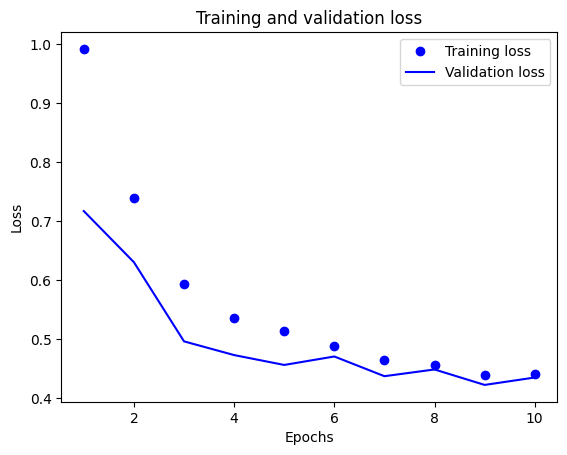

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc  = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

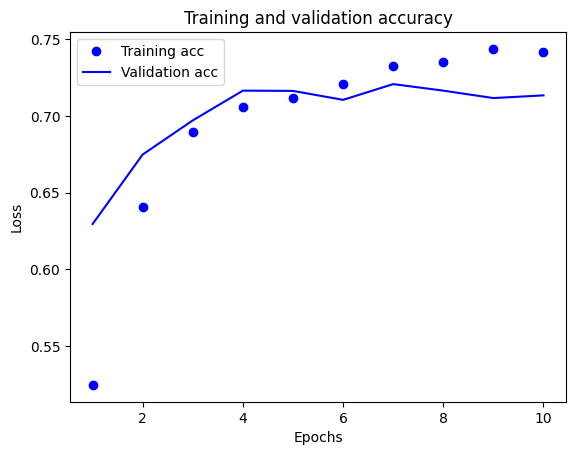

In [ ]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
from keras import backend as K
filepath = MODEL_CHECKPOINT_PATH + 'model-15-0.41.hdf5'
# load the model
loaded_model = load_model(filepath)
K.set_value(loaded_model.optimizer.lr,1e-6)
loaded_model.summary()
history = loaded_model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 35, 35, 96)        11712     
                                                                 
 activation_9 (Activation)   (None, 35, 35, 96)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 activation_10 (Activation)  (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                  

KeyboardInterrupt: ignored